In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer # Import SimpleImputer

In [2]:
#repoducibility
np.random.seed(42)

In [3]:
#preprocess the dataset
data = pd.read_csv('weather_data.csv')

In [4]:
print("Initial Dataset Shape:", data.shape)

Initial Dataset Shape: (311, 7)


In [5]:
print(data.head())

         date  avg_temperature   humidity  avg_wind_speed rain_or_not  \
0  2023-01-01        23.745401  46.140905        7.845981        Rain   
1  2023-01-02        30.030503  59.876587        5.382457        Rain   
2  2023-01-03        28.365224  51.464618       13.158008        Rain   
3  2023-01-04        27.550929  53.103799        5.886677        Rain   
4  2023-01-05        23.639303  57.826186       12.248992        Rain   

   cloud_cover     pressure  
0    20.851051   992.965681  
1    93.059521  1037.273025  
2    11.636640  1034.193357  
3    81.744971   968.610142  
4    38.062329  1030.264331  


In [6]:
#convert it to binary (if 1 = Rain, if 0 = No Rain)
data['rain_or_not']= data['rain_or_not'].map({'Rain': 1, 'No Rain': 0})

In [7]:
#checking the missing values and handle those with imputation
imputer = SimpleImputer(strategy='mean')
numeric_cols = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

In [8]:
#dropping rows
data.dropna(subset=['rain_or_not'], inplace=True)

In [9]:
#Outlier detection and capping
data['avg_wind_speed'] = data['avg_wind_speed'].clip(upper=50)

In [10]:
#lagged feture(shift by 1 day)
for col in numeric_cols:
    data[f'{col}_lag1'] = data[col].shift(1)
data.dropna(inplace=True)

In [11]:
#Interaction term
data['humidity_cloud_interaction'] = data['humidity'] * data['cloud_cover']

In [12]:
#make sure there's no missing values remain
print("Missing Values After Imputation:\n", data.isnull().sum())
print("Dataset Shape After Preprocessing:", data.shape)

Missing Values After Imputation:
 date                          0
avg_temperature               0
humidity                      0
avg_wind_speed                0
rain_or_not                   0
cloud_cover                   0
pressure                      0
avg_temperature_lag1          0
humidity_lag1                 0
avg_wind_speed_lag1           0
cloud_cover_lag1              0
pressure_lag1                 0
humidity_cloud_interaction    0
dtype: int64
Dataset Shape After Preprocessing: (310, 13)


In [13]:
#drop cloumns that are not a features for prediction
data = data.drop('date', axis=1)

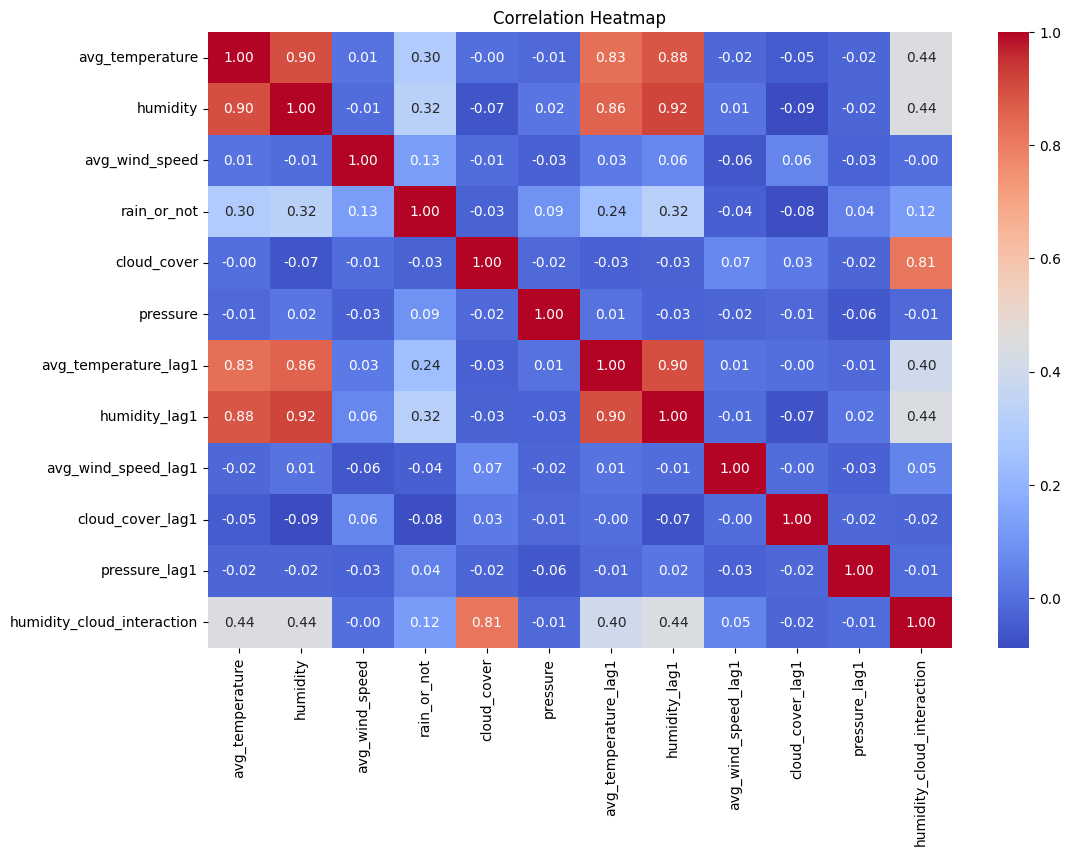

In [14]:
# EDA- correlation heatmap
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

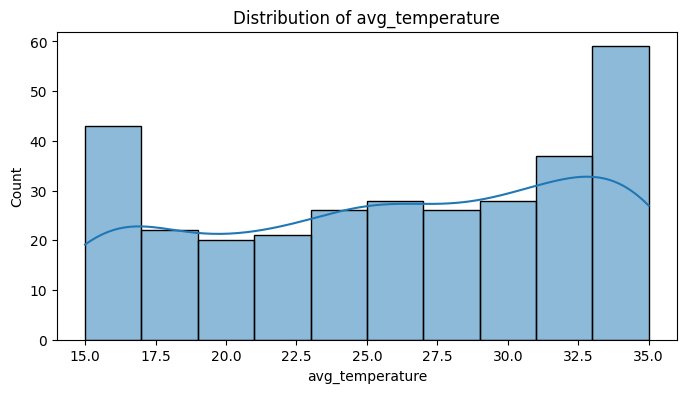

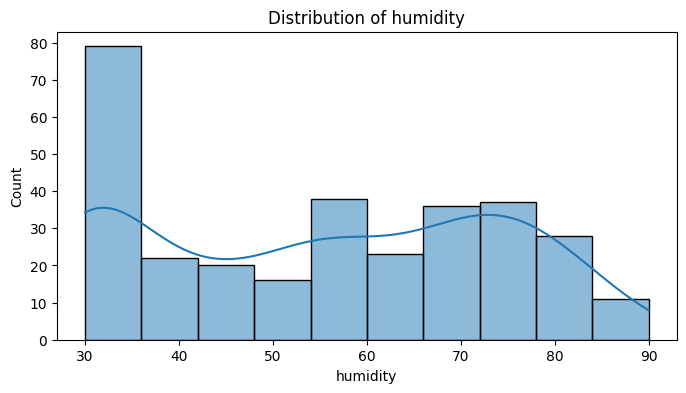

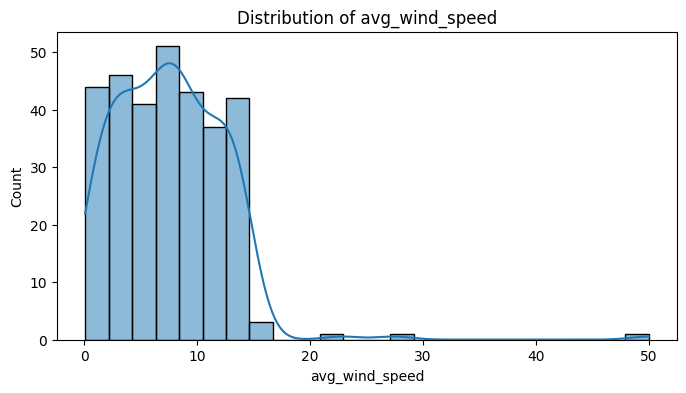

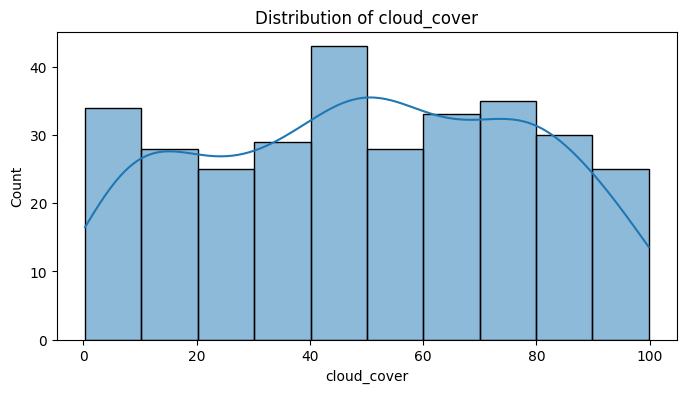

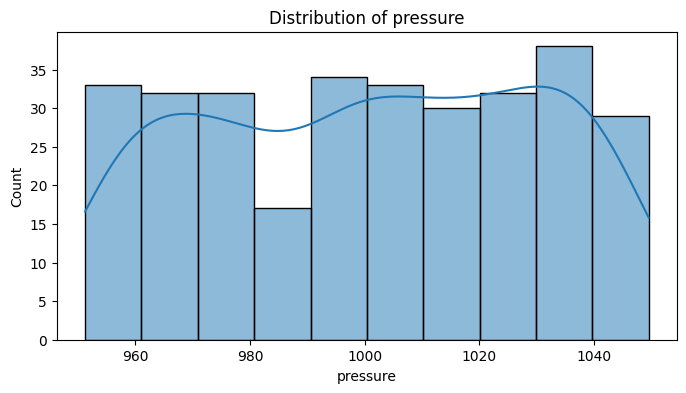

In [15]:
#distribution of feature
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

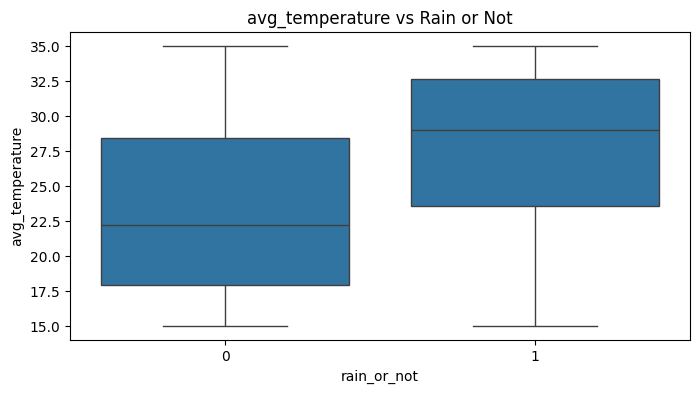

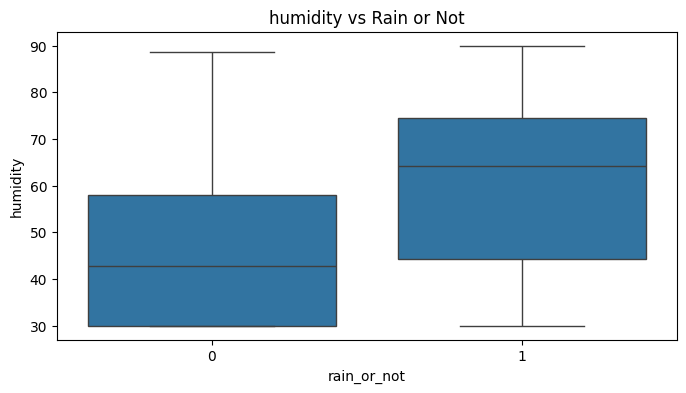

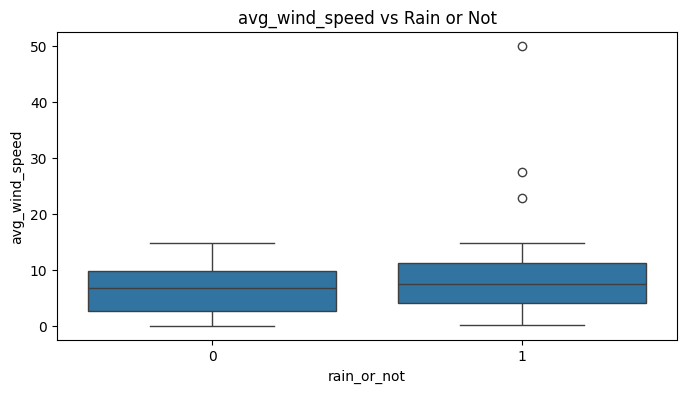

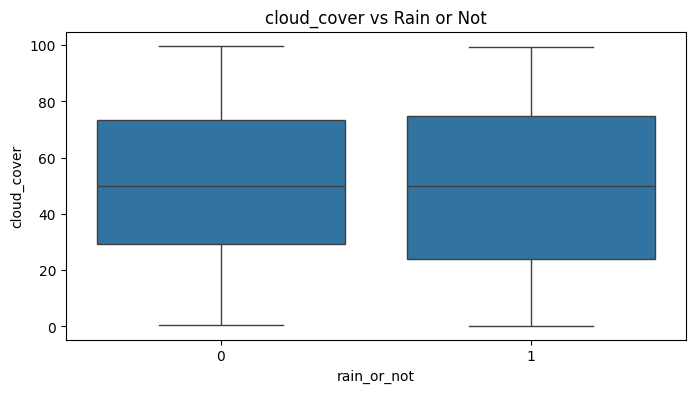

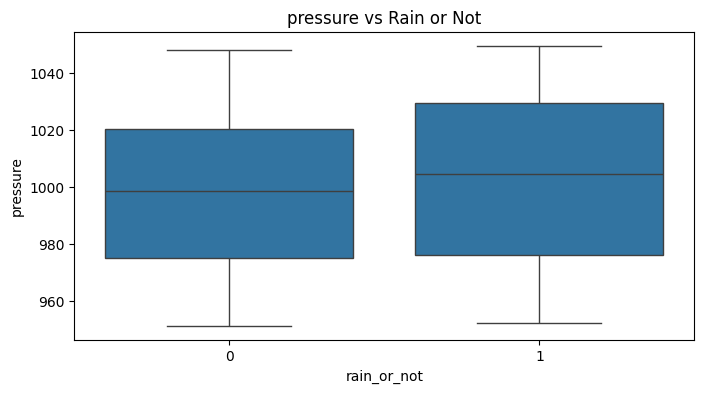

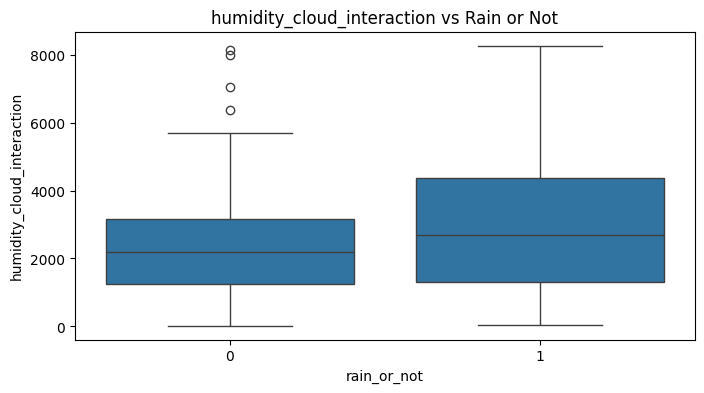

In [16]:
#Boxplot to check relationhsip with target
for col in numeric_cols+ ['humidity_cloud_interaction']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='rain_or_not', y=col, data=data)
    plt.title(f'{col} vs Rain or Not')
    plt.show()

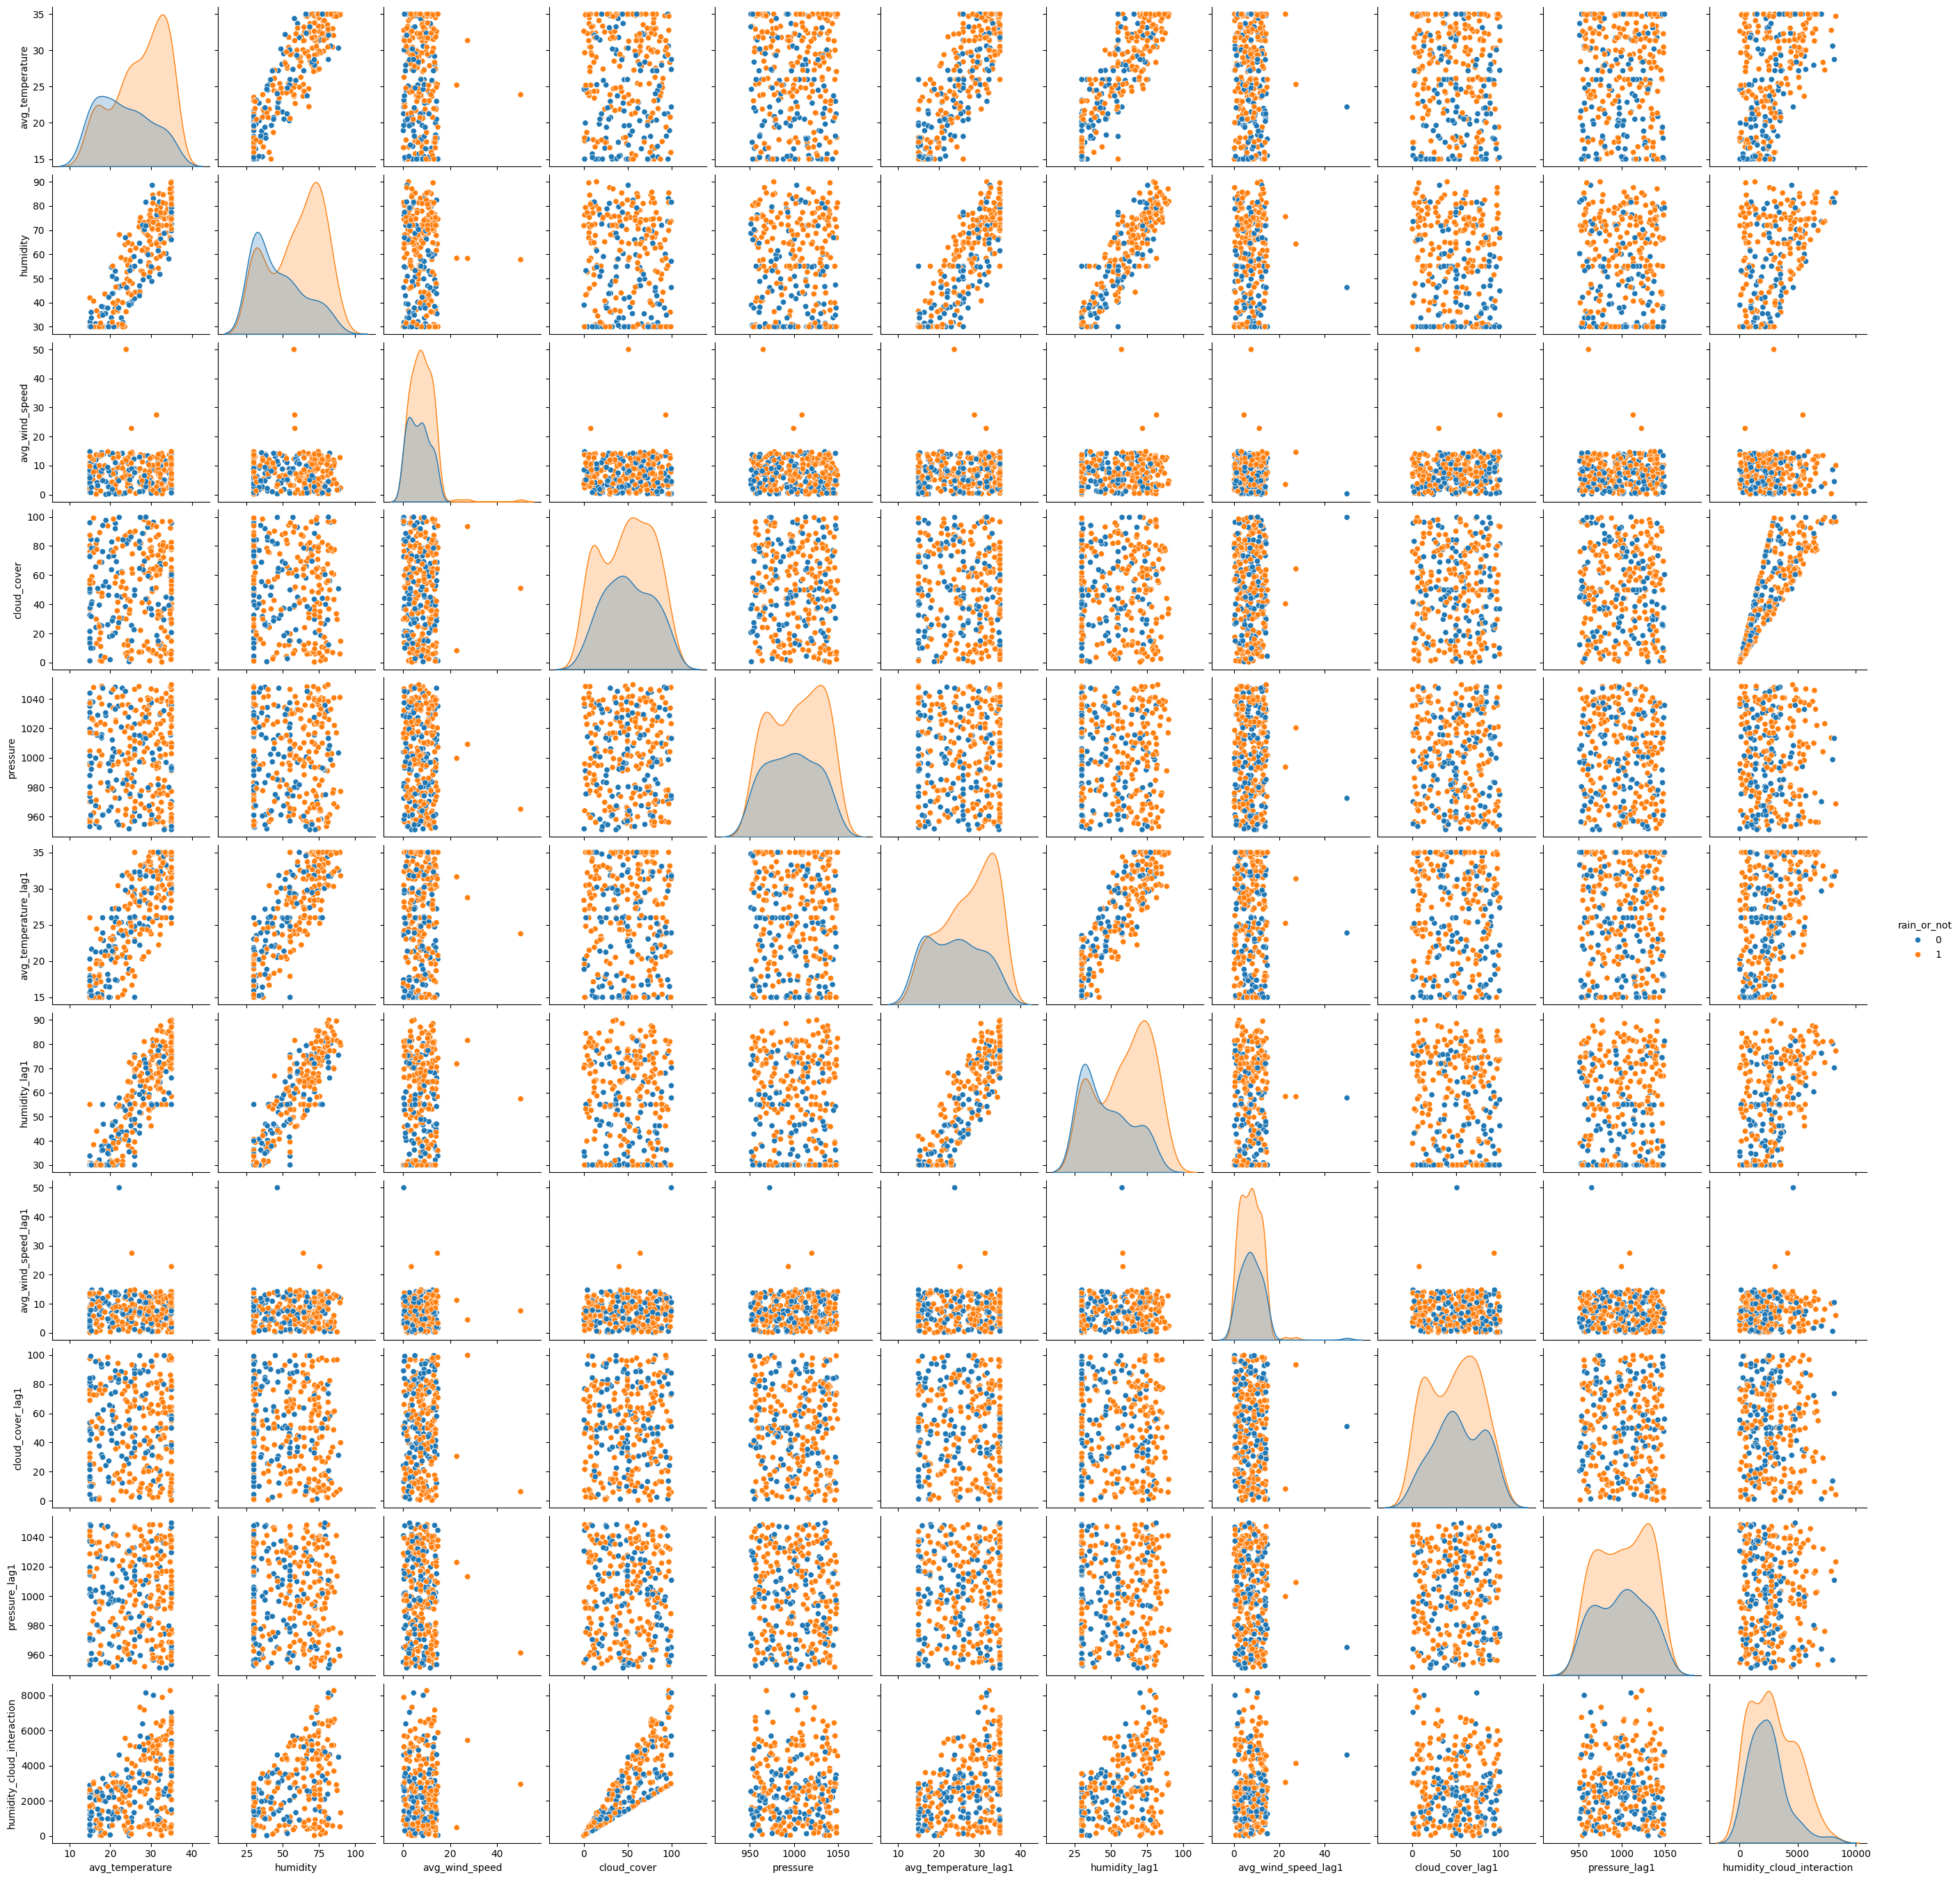

In [17]:
#visualize feature interations
sns.pairplot(data, hue='rain_or_not', diag_kind='kde')
plt.show()

In [18]:
#Split Data(featuers and target)
X = data.drop('rain_or_not', axis=1)
y = data['rain_or_not']

In [19]:
# Check class distribution
print("Class Distribution:\n", y.value_counts(normalize=True))

Class Distribution:
 rain_or_not
1    0.635484
0    0.364516
Name: proportion, dtype: float64


In [20]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [21]:
#train & evaluate ML models
#(define pipelines)
scaler = StandardScaler()

In [22]:
#Logistic regression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
lr_pipeline = Pipeline([
    ('scaler', scaler),
    ('selector', SelectKBest(f_classif, k=8)),
    ('model', LogisticRegression(class_weight='balanced'))
])

In [23]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
dt_pipeline = Pipeline([
    ('scaler', scaler),
    ('selector', SelectKBest(f_classif, k=8)),
    ('model', DecisionTreeClassifier(random_state=42))
])

In [24]:
#Random Forest
rf_pipeline = Pipeline([
    ('scaler', scaler),
    ('selector', SelectKBest(f_classif, k=8)),
    ('model', RandomForestClassifier(random_state=42,class_weight='balanced'))
])

In [25]:
#Gradient boosting
from sklearn.ensemble import GradientBoostingClassifier
gb_pipeline = Pipeline([
    ('scaler', scaler),
    ('selector', SelectKBest(f_classif, k=8)),
    ('model', GradientBoostingClassifier(random_state=42))
])

In [26]:
#XGBoost pipeline
xgb_pipeline = Pipeline([
    ('scaler', scaler),
    ('selector', SelectKBest(f_classif, k=8)),
    ('model', XGBClassifier(random_state=42, eval_metric='logloss'))
])

In [27]:
#evaluate each model
pipelines = {
    'Logistic Regression': lr_pipeline,
    'Decision Tree': dt_pipeline,
    'Random Forest': rf_pipeline,
    'Gradient Boosting': gb_pipeline,
    'XGBoost': xgb_pipeline
}

In [28]:
def evaluate_model(pipeline, X_test, y_test, model_name):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"\n{model_name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return pipeline

trained_models = {}
for name, pipeline in pipelines.items():
    trained_models[name] = evaluate_model(pipeline, X_test, y_test, name)


Logistic Regression Results:
Accuracy: 0.7096774193548387
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.70      0.64        23
           1       0.80      0.72      0.76        39

    accuracy                           0.71        62
   macro avg       0.70      0.71      0.70        62
weighted avg       0.72      0.71      0.71        62

Confusion Matrix:
 [[16  7]
 [11 28]]

Decision Tree Results:
Accuracy: 0.6290322580645161
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.48      0.49        23
           1       0.70      0.72      0.71        39

    accuracy                           0.63        62
   macro avg       0.60      0.60      0.60        62
weighted avg       0.63      0.63      0.63        62

Confusion Matrix:
 [[11 12]
 [11 28]]

Random Forest Results:
Accuracy: 0.5967741935483871
Classification Report:
               precision    recall

In [29]:
#Optimize the best model
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga'],
    'selector__k': [5, 8, 10]
}

grid_search_lr = GridSearchCV(
    pipelines['Logistic Regression'],
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1
)
grid_search_lr.fit(X_train, y_train)


print("\nBest Parameters for Logistic Regression:", grid_search_lr.best_params_)
print("Best Cross-Validation Score:", grid_search_lr.best_score_)


Best Parameters for Logistic Regression: {'model__C': 0.1, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'selector__k': 5}
Best Cross-Validation Score: 0.6811428571428572


In [30]:
## Evaluate tuned model
best_model = evaluate_model(grid_search_lr.best_estimator_, X_test, y_test, "Tuned Logistic Regression")


Tuned Logistic Regression Results:
Accuracy: 0.5967741935483871
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.48      0.47        23
           1       0.68      0.67      0.68        39

    accuracy                           0.60        62
   macro avg       0.57      0.57      0.57        62
weighted avg       0.60      0.60      0.60        62

Confusion Matrix:
 [[11 12]
 [13 26]]


In [31]:
#Optimize the best model
param_grid = {
    'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'model__solver': ['liblinear', 'saga'],
    'selector__k': [5, 8, 10]
}

grid_search = GridSearchCV(
    pipelines['XGBoost'],
    param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)


print("\nBest Parameters for XGBoost:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)


Best Parameters for XGBoost: {'model__C': 0.001, 'model__penalty': 'l1', 'model__solver': 'liblinear', 'selector__k': 10}
Best Cross-Validation Score: 0.6413061224489796


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:05:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "C", "penalty", "solver" } are not used.

  warnings.warn(smsg, UserWarning)


In [32]:
## Evaluate tuned model
best_model = evaluate_model(grid_search.best_estimator_, X_test, y_test, "Tuned XGBoost")


Tuned XGBoost Results:
Accuracy: 0.532258064516129
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.22      0.26        23
           1       0.61      0.72      0.66        39

    accuracy                           0.53        62
   macro avg       0.46      0.47      0.46        62
weighted avg       0.50      0.53      0.51        62

Confusion Matrix:
 [[ 5 18]
 [11 28]]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [12:05:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "C", "penalty", "solver" } are not used.

  warnings.warn(smsg, UserWarning)



Feature Importance in Tuned XGBoost:
                       Feature  Importance
1                    humidity    0.227996
0             avg_temperature    0.098620
7            cloud_cover_lag1    0.098567
6               humidity_lag1    0.094094
8               pressure_lag1    0.087838
5        avg_temperature_lag1    0.085807
9  humidity_cloud_interaction    0.082541
4                    pressure    0.078669
2              avg_wind_speed    0.075865
3                 cloud_cover    0.070003


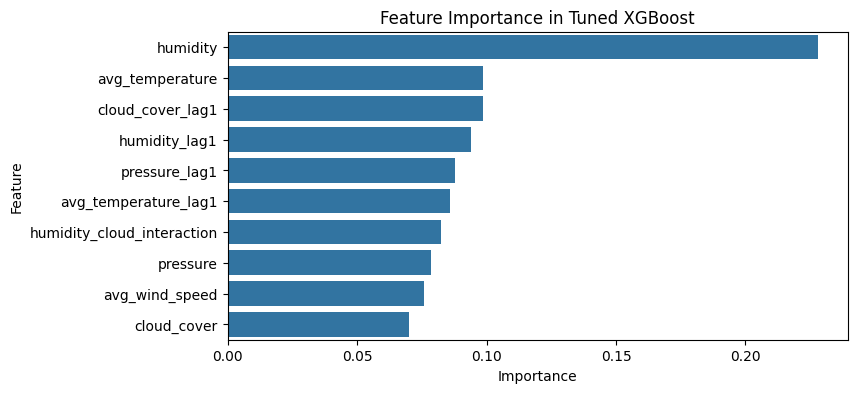

In [33]:
# Feature importance for XGBoost
# Assuming 'grid_search' was fitted using XGBoost pipeline earlier
selected_features_xgb = X.columns[grid_search.best_estimator_.named_steps['selector'].get_support()]
feature_importance_xgb = pd.DataFrame({
    'Feature': selected_features_xgb,
    'Importance': grid_search.best_estimator_.named_steps['model'].feature_importances_
})
feature_importance_xgb = feature_importance_xgb.sort_values('Importance', ascending=False)
print("\nFeature Importance in Tuned XGBoost:\n", feature_importance_xgb)

plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_xgb)
plt.title('Feature Importance in Tuned XGBoost')
plt.show()

In [35]:
import numpy as np
import pandas as pd

# Predicting probabilities for Next 21 days

num_days = 21
future_data = pd.DataFrame()

# Get training columns from X_train
training_columns = X_train.columns



for col in training_columns:  # Use the training columns as before
    if col in ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']:

        # drift for numerical features
        drift = (data[col].iloc[-1] - data[col].iloc[0]) / len(data)
        values = [data[col].iloc[-1]]
        for _ in range(num_days - 1):
            values.append(values[-1] + drift + np.random.normal(scale=data[col].std() / 5))
        future_data[col] = values
    elif col in ['avg_temperature_lag1', 'humidity_lag1', 'avg_wind_speed_lag1', 'cloud_cover_lag1', 'pressure_lag1']:

        # Shift previous values for lagged features
        future_data[col] = future_data[col[:-5]].shift(1).fillna(method='bfill')
    else:

        # Calculate interaction term
        future_data['humidity_cloud_interaction'] = future_data['humidity'] * future_data['cloud_cover']

rain_probabilities = best_model.predict_proba(future_data)[:, 1]
future_dates = pd.date_range(start='2023-11-08', periods=num_days, freq='D')

print("\nRain Probability for Next 21 Days:")
for date, prob in zip(future_dates, rain_probabilities):
    print(f"{date.strftime('%Y-%m-%d')}: {prob:.2%}")


Rain Probability for Next 21 Days:
2023-11-08: 5.65%
2023-11-09: 84.57%
2023-11-10: 34.92%
2023-11-11: 18.88%
2023-11-12: 3.75%
2023-11-13: 2.28%
2023-11-14: 0.98%
2023-11-15: 88.62%
2023-11-16: 73.01%
2023-11-17: 42.29%
2023-11-18: 49.50%
2023-11-19: 15.50%
2023-11-20: 22.04%
2023-11-21: 10.04%
2023-11-22: 86.13%
2023-11-23: 77.45%
2023-11-24: 58.25%
2023-11-25: 38.31%
2023-11-26: 70.00%
2023-11-27: 67.64%
2023-11-28: 9.51%


<ipython-input-35-0ebcecb4483e>:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_data[col] = future_data[col[:-5]].shift(1).fillna(method='bfill')
<ipython-input-35-0ebcecb4483e>:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_data[col] = future_data[col[:-5]].shift(1).fillna(method='bfill')
<ipython-input-35-0ebcecb4483e>:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_data[col] = future_data[col[:-5]].shift(1).fillna(method='bfill')
<ipython-input-35-0ebcecb4483e>:26: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_data[col] = future_data[col[:-5]].shift(1).fillna(method='bfill')
<ipython-input-35-0ebcec

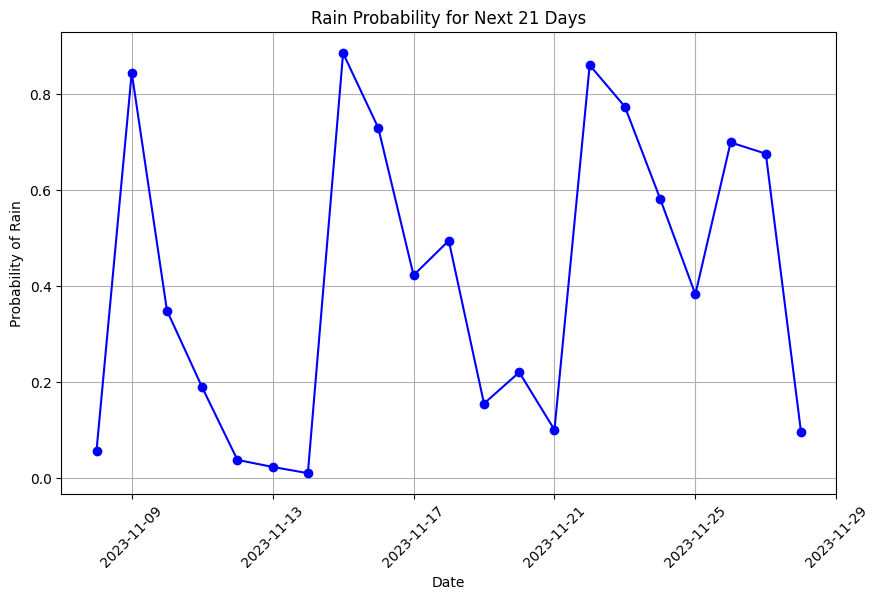

In [36]:
#visualize the probabilities
plt.figure(figsize=(10, 6))
plt.plot(future_dates, rain_probabilities, marker='o', color='blue')
plt.title('Rain Probability for Next 21 Days')
plt.xlabel('Date')
plt.ylabel('Probability of Rain')
plt.xticks(rotation=45)
plt.grid()
plt.show()


Feature Importance in Tuned Logistic Regression:
                       Feature  Importance
1                    humidity    0.443996
3               humidity_lag1    0.295887
0             avg_temperature    0.214258
2        avg_temperature_lag1    0.171068
4  humidity_cloud_interaction    0.114285


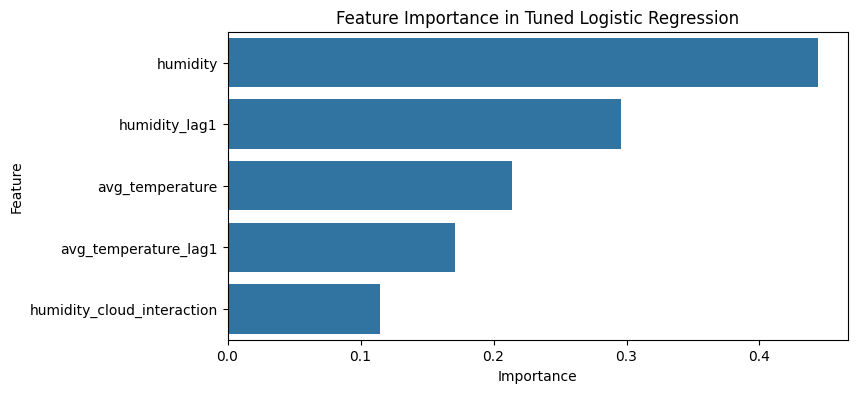

In [37]:
# Feature importance for Logistic Regression
# Assuming 'grid_search_lr' was fitted using Logistic Regression pipeline
selected_features_lr = X.columns[grid_search_lr.best_estimator_.named_steps['selector'].get_support()]
feature_importance_lr = pd.DataFrame({
    'Feature': selected_features_lr,
    'Importance': np.abs(grid_search_lr.best_estimator_.named_steps['model'].coef_[0])
})
feature_importance_lr = feature_importance_lr.sort_values('Importance', ascending=False)
print("\nFeature Importance in Tuned Logistic Regression:\n", feature_importance_lr)

plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance_lr)
plt.title('Feature Importance in Tuned Logistic Regression')
plt.show()

In [38]:
import numpy as np
import pandas as pd

# Predicting probabilities for Next 21 days

num_days = 21
future_data = pd.DataFrame()

# Get training columns from X_train
training_columns = X_train.columns

for col in training_columns:  # Use the training columns as before
    if col in ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']:

        # drift for numerical features
        drift = (data[col].iloc[-1] - data[col].iloc[0]) / len(data)
        values = [data[col].iloc[-1]]
        for _ in range(num_days - 1):
            values.append(values[-1] + drift + np.random.normal(scale=data[col].std() / 5))
        future_data[col] = values
    elif col in ['avg_temperature_lag1', 'humidity_lag1', 'avg_wind_speed_lag1', 'cloud_cover_lag1', 'pressure_lag1']:

        # Shift previous values for lagged features
        future_data[col] = future_data[col[:-5]].shift(1).fillna(method='bfill')
    else:

        # Calculate interaction term
        future_data['humidity_cloud_interaction'] = future_data['humidity'] * future_data['cloud_cover']

rain_probabilities = best_model.predict_proba(future_data)[:, 1]
future_dates = pd.date_range(start='2023-11-08', periods=num_days, freq='D')

print("\nRain Probability for Next 21 Days:")
for date, prob in zip(future_dates, rain_probabilities):
    print(f"{date.strftime('%Y-%m-%d')}: {prob:.2%}")


Rain Probability for Next 21 Days:
2023-11-08: 5.65%
2023-11-09: 30.57%
2023-11-10: 8.51%
2023-11-11: 70.82%
2023-11-12: 95.86%
2023-11-13: 52.09%
2023-11-14: 9.32%
2023-11-15: 6.20%
2023-11-16: 22.16%
2023-11-17: 24.12%
2023-11-18: 93.42%
2023-11-19: 41.93%
2023-11-20: 59.30%
2023-11-21: 50.12%
2023-11-22: 46.75%
2023-11-23: 63.54%
2023-11-24: 81.62%
2023-11-25: 87.14%
2023-11-26: 88.70%
2023-11-27: 90.88%
2023-11-28: 82.52%


<ipython-input-38-dda1b500e2a5>:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_data[col] = future_data[col[:-5]].shift(1).fillna(method='bfill')
<ipython-input-38-dda1b500e2a5>:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_data[col] = future_data[col[:-5]].shift(1).fillna(method='bfill')
<ipython-input-38-dda1b500e2a5>:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_data[col] = future_data[col[:-5]].shift(1).fillna(method='bfill')
<ipython-input-38-dda1b500e2a5>:24: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  future_data[col] = future_data[col[:-5]].shift(1).fillna(method='bfill')
<ipython-input-38-dda1b5

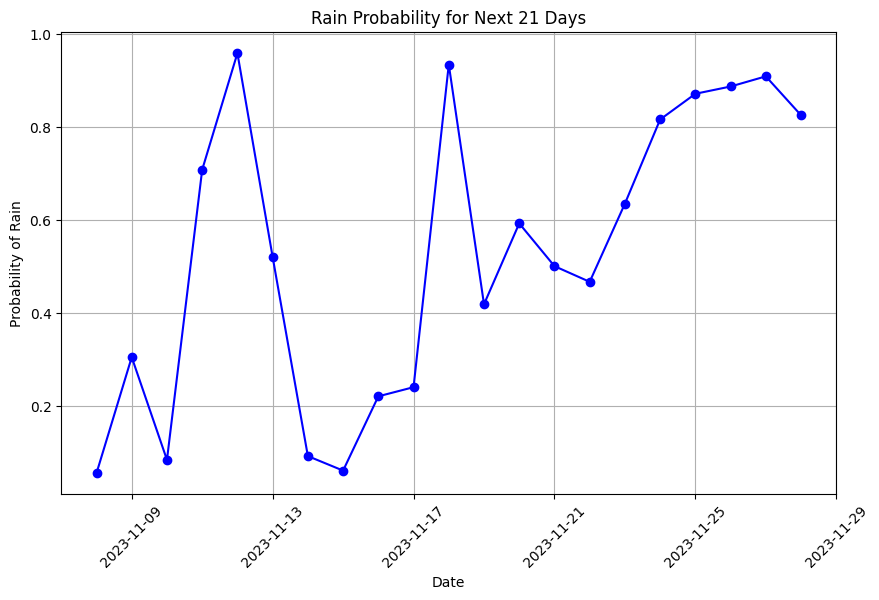

In [39]:
#visualize the probabilities
plt.figure(figsize=(10, 6))
plt.plot(future_dates, rain_probabilities, marker='o', color='blue')
plt.title('Rain Probability for Next 21 Days')
plt.xlabel('Date')
plt.ylabel('Probability of Rain')
plt.xticks(rotation=45)
plt.grid()
plt.show()